# Fahrspurerkennung

In [3]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

## 1. Gelb → Weiß

(720, 1280, 3)
(720, 1280)
(720, 1280, 3)


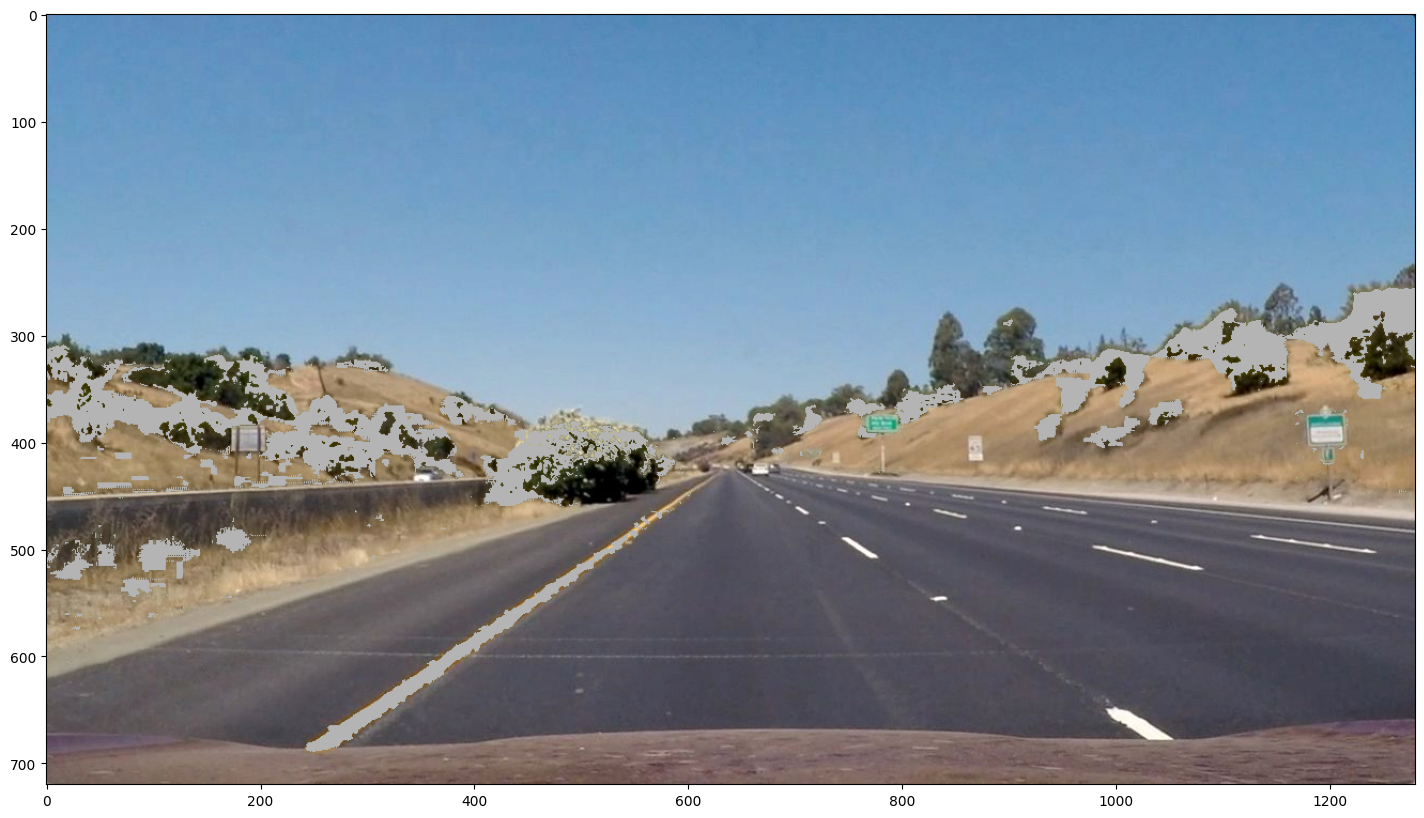

In [20]:
img = cv.imread("images/image001.jpg", cv.IMREAD_COLOR)
img = cv.cvtColor(img, cv.COLOR_BGR2HSV)
yellow_low = (20, 75 , 75)
yellow_high = (40, 255, 255)
print(img.shape)
img_yellow = cv.inRange(img, yellow_low, yellow_high)
print(img_yellow.shape)
img_f = img.copy()
img_f[np.where(img_yellow > 0)] = (0, 0, 180)
img_f = cv.cvtColor(img_f, cv.COLOR_HSV2RGB)
print(img_f.shape)

plt.figure(figsize=(20,10))
plt.imshow(img_f)
plt.show()

## 2. Grauwertbild